## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [38]:
import os

import pandas as pd
import numpy as np
import s3fs
import zipfile
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### Récupérer les données d'un challenge

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [5]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [6]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [7]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

### Lecture des fichiers

In [8]:
file = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [11]:
file

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

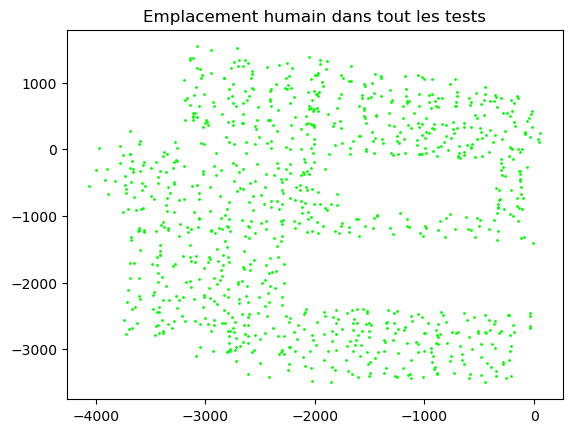

In [30]:
plt.plot([tab_file[0] for tab_file in file], [tab_file2[1] for tab_file2 in file], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()

In [35]:
#audio = np.load('data/TreatedRoomSmallSet/Human1/audio.npy')
#adjusted_audio = np.load('data/TreatedRoomSmallSet/Human1/adjusted_audio.npy')

rir = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
#directlines = np.load('data/TreatedRoomSmallSet/Human1/directlines.npy')
rir

array([[[ 9.07240337e-06,  1.71257434e-05,  1.22597794e-05, ...,
          8.86178623e-06,  1.40686043e-05,  1.06616626e-05],
        [-8.23853679e-06, -8.23373648e-06, -8.74563466e-06, ...,
          2.87394778e-06, -8.90485808e-06, -3.52464713e-06],
        [ 6.62780906e-07, -1.40201587e-06,  1.83228190e-06, ...,
         -1.06218545e-06,  8.53497477e-06,  2.28155182e-06],
        [ 8.11119719e-07, -2.47451499e-06,  5.82140547e-06, ...,
          7.73804004e-06,  2.29692650e-05,  1.10566034e-05]],

       [[ 1.64466037e-05,  1.53698293e-05,  1.91599720e-05, ...,
          1.76548729e-05,  1.70955263e-05,  1.41169767e-05],
        [ 1.05826217e-07,  9.13145777e-06,  1.76140716e-07, ...,
          1.21369967e-05,  1.55958387e-05,  1.23088676e-05],
        [ 7.06836090e-06,  3.26818258e-06,  7.15508941e-06, ...,
          4.64980394e-06,  8.96262554e-06,  6.55734584e-06],
        [-3.18089551e-05, -8.93297238e-06, -2.51026504e-05, ...,
         -7.02741545e-07,  1.34268867e-05,  3.24307

In [36]:
len(rir[0])
print(" ")
len(rir[0][0])

print(rir[0])
print(len(rir[0][0]))

 
[[ 9.0724034e-06  1.7125743e-05  1.2259779e-05 ...  8.8617862e-06
   1.4068604e-05  1.0661663e-05]
 [-8.2385368e-06 -8.2337365e-06 -8.7456347e-06 ...  2.8739478e-06
  -8.9048581e-06 -3.5246471e-06]
 [ 6.6278091e-07 -1.4020159e-06  1.8322819e-06 ... -1.0621854e-06
   8.5349748e-06  2.2815518e-06]
 [ 8.1111972e-07 -2.4745150e-06  5.8214055e-06 ...  7.7380400e-06
   2.2969265e-05  1.1056603e-05]]
667200


In [52]:
# Compute RMS levels
RMS_levels = np.sqrt(np.mean(rir**2, axis=2))  # compute RMS along the samples axis
print(RMS_levels)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]


In [53]:
# Flatten RMS levels
#flattened_RMS = RMS_levels.reshape(RMS_levels.shape[0], -1)
#print(flattened_RMS)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]


In [55]:
# Normalize RMS levels
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)
print(normalized_RMS)

[[  0.807686     0.89319843   0.3703625    0.55446833]
 [  0.6148092    0.5601817    0.32530993   0.49623522]
 [  0.6670591    0.46835804   0.26275572   0.5050229 ]
 ...
 [  0.48971906   0.02091012  -0.3304132   -0.05839473]
 [  0.38563752  -0.5528933   -0.33424938  -0.18044513]
 [  0.38350895   0.30132347 -10.254325    -4.594716  ]]


In [56]:
# Initialize k-NN model
k = 5  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')  # Using weighted k-NN
knn.fit(normalized_RMS, file)

KNeighborsRegressor(weights='distance')

In [45]:
# Query RMS levels (choose any RMS levels from your dataset as a query)
query_index = 0
query_RMS = normalized_RMS[query_index].reshape(1, -1)

In [46]:
# Predict human position using k-NN
predicted_position = knn.predict(query_RMS)

print("Predicted human position:", predicted_position)

Predicted human position: [[-3231.3293467  -1127.87771457]]


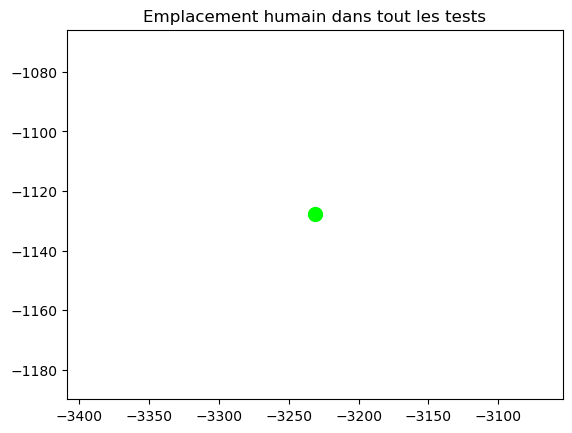

In [51]:


plt.plot([file[0][0], ], [file[0][1]], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 10)
plt.title('Emplacement humain dans tout les tests')
plt.show()